In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd

from csv import reader
import skimage
from skimage import io, transform, exposure, data, color
from skimage.color import *
import sys

import PIL
from PIL import Image

BBBC038 = "/raid/data/BBBC038/"
training_imgs_dir = "/raid/data/BBBC038/training/"

In [2]:
def extract_features(im):
    im = skimage.exposure.rescale_intensity(im)
    color_hist = []
    for c in range(3):
        if len(im.shape) == 3:
            color_hist.append( np.histogram(im[:,:,c], 255)[0] ) # computes histogram of 255 pixel values (0 is black)
        else:
            color_hist.append( np.histogram(im[:,:], 255)[0] )
    feat = np.concatenate(color_hist)
    feat = feat / (im.shape[0] * im.shape[1] * 3 )
    return np.expand_dims(feat, axis=0)

In [3]:
def getImage(path,zoom=0.08): # redistributes intensity of an image so bright pixels are more prominent
    im = skimage.io.imread(path)
    im = skimage.exposure.equalize_adapthist(im)
    return OffsetImage(im,zoom=zoom)

# View sample image

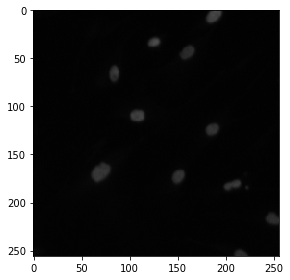

In [4]:
sample_dir = "/raid/data/BBBC038/training/ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0/"
os.listdir(sample_dir + 'images/')
io.imshow(sample_dir + 'images/ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0.png')

# Load All Data

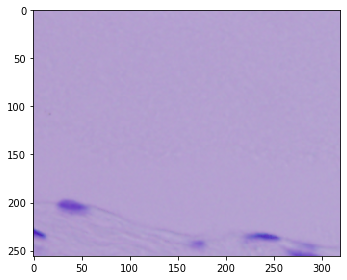

In [40]:
im_paths = []
mk_paths = []

for im_path in os.listdir(training_imgs_dir):
    path_masks = f"{training_imgs_dir}/{im_path}/masks/{im_path}"
    path_image = f"{training_imgs_dir}/{im_path}/images/{im_path}.png"

    mk_paths.append(path_masks)
    im_paths.append(path_image)

# sample
io.imshow(im_paths[100])


# Load All Labeled Data

In [6]:
image_groups = pd.read_csv(BBBC038 + "training_classifications.csv")
full_name = []

for i, image_name in image_groups.iterrows():
    full_name.append(image_name)
    
# image_groups[image_groups["Type"] == "Purple"]
# full_name[2][1]
# image_groups["Type"].unique()

In [7]:
csv_lines = []
with open(BBBC038 + "training_classifications.csv") as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        csv_lines.append(row)

# Find all Purple images and masks in directory

In [8]:
purple_png_list = []

for row in csv_lines:
    if "Purple" in row:
        purple_png_list.append(row[1])

# len(purple_png_list) # 104, as expected

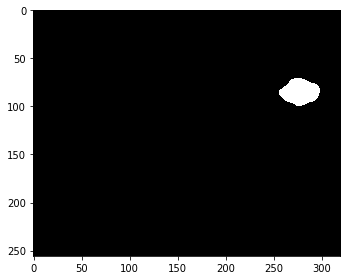

In [61]:
purp_collections = []
for i in range(104):
    curr_img_path = training_imgs_dir + purple_png_list[i][:-4] + "/masks/*.png"
    imcoll = io.collection.ImageCollection(curr_img_path)
    purp_collections.append(imcoll)
    
# first index is image collection, second is mask within collection
io.imshow(purp_collections[3][0])

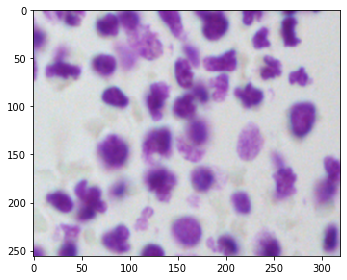

In [11]:
purp_sample_png_path = training_imgs_dir + purple_png_list[5][:-4] + "/images/" + purple_png_list[5]
purp_data = io.imread(purp_sample_png_path)
io.imshow(purp_data)

# Copy all images and masks in order to not damage dataset

In [48]:
purp_copies = []
copy_paths = []
mask_copies = []
copy_imgs_dir = "/raid/data/BBBC038/purp_imgs_copies/"
for i in range(104):
    curr_path = training_imgs_dir + purple_png_list[i][:-4]
    
    # get images, copy them and save them to copy directory
    purp_img = Image.open(curr_path + "/images/" + purple_png_list[i], 'r')
    copy = purp_img.copy()
    copy.save(copy_imgs_dir + purple_png_list[i])
    
    copy_paths.append(copy_imgs_dir + purple_png_list[i])
    purp_copies.append(copy)
    
    # get masks
    curr_masks_path = curr_path + "/masks/*.png"
    copy_coll = io.collection.ImageCollection(curr_img_path)
    
    mask_copies.append(copy_coll)

# Unmix Colors from Purple Images
* use separate stains (possibility)
    * did not work, separate stain couldn't reshape image (even when inputted as array-like object)

Utilize PIL library to get pixel information

In [12]:
# Get the pixel from the given image
def get_pixel(image, i, j):
    # Inside image bounds?
    width, height = image.size
    if i > width or j > height:
      return None

    # Get Pixel
    pixel = image.getpixel((i, j))
    return pixel

In [14]:
# returns sorted list of occurrences a given RGBA color appears in an image
colors = purp_copies[5].getcolors(purp_copies[5].size[0] * purp_copies[5].size[1])
colors.sort()
# print(colors)

In [15]:
# returns minimum and maximum pixel value for each band
extrema = purp_copies[5].getextrema()
print(extrema)

((73, 234), (26, 230), (116, 246), (255, 255))


# Attempt at recreating Cell Profiler Unmix Colors
* Did not work; requires too many dependencies within cell profiler that are not easily translated 

In [27]:
import cellprofiler.gui.help.content
import cellprofiler_core.image as cpi
import cellprofiler_core.module as cpm
import cellprofiler_core.preferences as cpprefs
import cellprofiler_core.setting as cps

CHOICE_HEMATOXYLIN = "Hematoxylin"
ST_HEMATOXYLIN = (0.644, 0.717, 0.267)

CHOICE_EOSIN = "Eosin"
ST_EOSIN = (0.093, 0.954, 0.283)

CHOICE_DAB = "DAB"
ST_DAB = (0.268, 0.570, 0.776)

CHOICE_FAST_RED = "Fast red"
ST_FAST_RED = (0.214, 0.851, 0.478)

CHOICE_FAST_BLUE = "Fast blue"
ST_FAST_BLUE = (0.749, 0.606, 0.267)

CHOICE_METHYL_BLUE = "Methyl blue"
ST_METHYL_BLUE = (0.799, 0.591, 0.105)

CHOICE_METHYL_GREEN = "Methyl green"
ST_METHYL_GREEN = (0.980, 0.144, 0.133)

CHOICE_AEC = "AEC"
ST_AEC = (0.274, 0.679, 0.680)

CHOICE_ANILINE_BLUE = "Aniline blue"
ST_ANILINE_BLUE = (0.853, 0.509, 0.113)

CHOICE_AZOCARMINE = "Azocarmine"
ST_AZOCARMINE = (0.071, 0.977, 0.198)

CHOICE_ALICAN_BLUE = "Alican blue"
ST_ALICAN_BLUE = (0.875, 0.458, 0.158)

CHOICE_PAS = "PAS"
ST_PAS = (0.175, 0.972, 0.155)

CHOICE_HEMATOXYLIN_AND_PAS = "Hematoxylin and PAS"
ST_HEMATOXYLIN_AND_PAS = (0.553, 0.754, 0.354)

CHOICE_FEULGEN = "Feulgen"
ST_FEULGEN = (0.464, 0.830, 0.308)

CHOICE_METHYLENE_BLUE = "Methylene blue"
ST_METHYLENE_BLUE = (0.553, 0.754, 0.354)

CHOICE_ORANGE_G = "Orange-G"
ST_ORANGE_G = (0.107, 0.368, 0.923)

CHOICE_PONCEAU_FUCHSIN = "Ponceau-fuchsin"
ST_PONCEAU_FUCHSIN = (0.100, 0.737, 0.668)

CHOICE_CUSTOM = "Custom"
STAIN_DICTIONARY = {
    CHOICE_AEC: ST_AEC,
    CHOICE_ALICAN_BLUE: ST_ALICAN_BLUE,
    CHOICE_ANILINE_BLUE: ST_ANILINE_BLUE,
    CHOICE_AZOCARMINE: ST_AZOCARMINE,
    CHOICE_DAB: ST_DAB,
    CHOICE_EOSIN: ST_EOSIN,
    CHOICE_FAST_BLUE: ST_FAST_BLUE,
    CHOICE_FAST_RED: ST_FAST_RED,
    CHOICE_FEULGEN: ST_FEULGEN,
    CHOICE_HEMATOXYLIN: ST_HEMATOXYLIN,
    CHOICE_HEMATOXYLIN_AND_PAS: ST_HEMATOXYLIN_AND_PAS,
    CHOICE_METHYL_BLUE: ST_METHYL_BLUE,
    CHOICE_METHYLENE_BLUE: ST_METHYLENE_BLUE,
    CHOICE_METHYL_GREEN: ST_METHYL_GREEN,
    CHOICE_ORANGE_G: ST_ORANGE_G,
    CHOICE_PAS: ST_PAS,
    CHOICE_PONCEAU_FUCHSIN: ST_PONCEAU_FUCHSIN,
}

ModuleNotFoundError: No module named 'cellprofiler'

In [24]:
input_img = purp_copies[5]
input_pix = purp_copies[5].load()
# input_pix[0, 0], input_img.getpixel((0, 0))

def get_absorbances(img, stain_choice):
    result = STAIN_DICTIONARY[stain_choice.value]
    result = np.array(results)
    result = result / np.sqrt(np.sum(result ** 2))
    
    return results

def get_inverse_absorbances(img):
    idx = purp_copies.index(img)
    absorbance_array = np.array([get_absorbances(o) for o in purp_copies])
    absorbance_matrix = np.matrix(absorbance_array)
    return np.array(absorbance_matrix.I[:, idx]).flatten()

def run_on_output_clone(input_img, )
inverse_absorbances = get_inverse_absorbances

((218, 219, 225, 255), (218, 219, 225, 255))

# Use cv2 to unmix colors

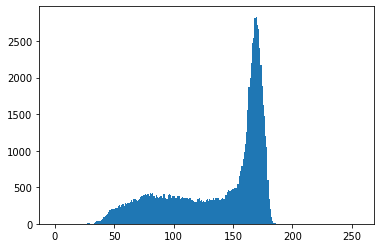

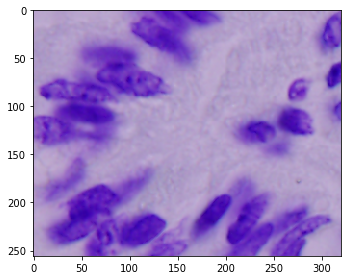

In [104]:
import cv2

img = cv2.imread(copy_paths[1])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([gray],[0],None,[256],[0,256])
colors = np.where(hist>5000)
# img_number = 0

for color in colors[0]:
    print(color)
    split_image = img.copy()
    split_image[np.where(gray != color)] = 0
#     cv2.imwrite(str(img_number)+".jpg",split_image)
#     img_number+=1
    
plt.hist(gray.ravel(),256,[0,256])
plt.show()
io.imshow(img) 
io.imshow(copy_paths[1])
# io.imshow(split_image)

# Identify most prominent color (may remove later, ML better suited for this task)
* open an image, turn it into an array
* find clusters
* count color occurrences
* find most frequent color

In [17]:
from __future__ import print_function
import binascii
import struct
from PIL import Image, ImageOps
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

def id_color(image):
    print('reading image')
    im = Image.open('/Users/ebueno/Desktop/Python Stuff/skimage-tutorials/images/fingers.png')
    im = im.resize((150, 150))      # optional, to reduce time
    ar = np.asarray(im)
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    print('finding clusters')
    NUM_CLUSTERS = 5
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
    print('cluster centres:\n', codes)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences

    index_max = np.argmax(counts)                    # find most frequent
    peak = codes[index_max]
    colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
    print('most frequent is %s (#%s)' % (peak, colour))
    return colour